# **Brief description of the problem and data**

This Kaggle competition is about classifying texts taken from Twitter using Natural Language Processing (NLP) to classify which are about real disasters and which are not. 

The complexity of the task is demonstrated using the sample Tweet provided by the competition: "LOOK AT THE NIGHT SKY LAST NIGHT IT WAS ABLAZE" where the author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away but it is less clear to a machine that it is not referencing a real disaster.

The dataset consists of 10,000 tweets that were hand classified.

# **Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import random
import wordcloud
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#from functools import reduce
#from nltk.stem import PorterStemmer, WordNetLemmatizer

# **Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [2]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


From a high level look at the datasets it is observed:

* The training set contains 7,613 entries while the testing dataset contains 3,263 entries
* Both datasets contain 4 columns: ID, Keyword, Location, Text
* The training dataset contains 1 additional column which we will be predicting for the test dataset: Target

We will evaluate the fields further below.


In [8]:
train_data['target'].value_counts().to_frame()

,target
0,4342
1,3271


Text(0, 0.5, 'Count')

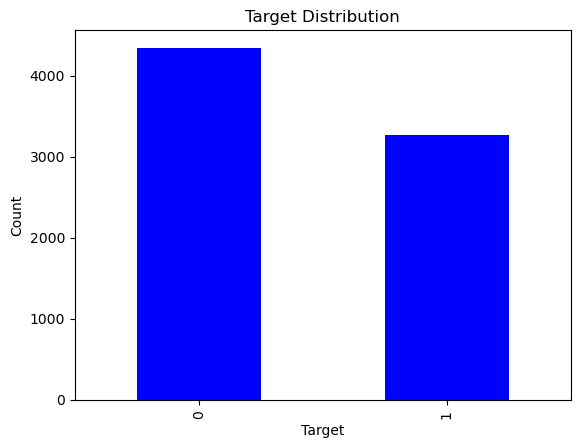

In [9]:
train_data.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

Text(0.5, 0, 'Count')

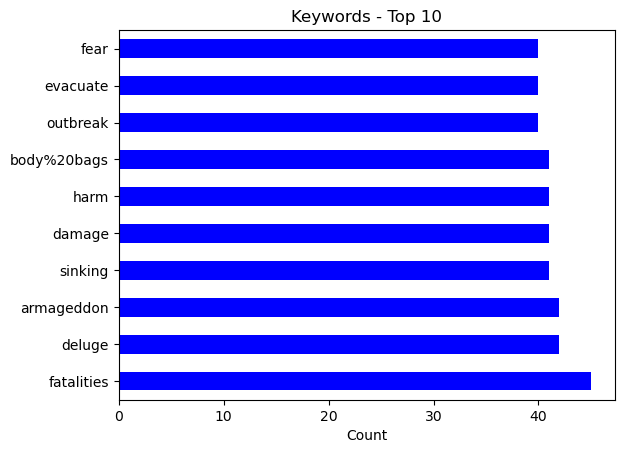

In [44]:
train_data['keyword'].value_counts()[:10].plot(kind='barh', color='blue')
plt.title("Keywords - Top 10")
plt.xlabel("Count")

Text(0.5, 0, 'Count')

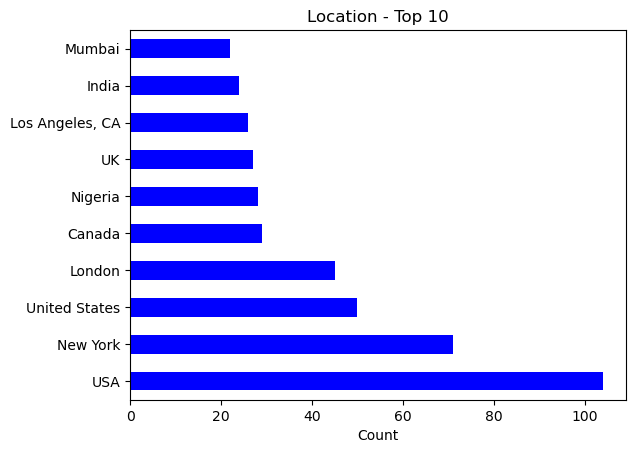

In [45]:
train_data['location'].value_counts()[:10].plot(kind='barh', color='blue')
plt.title("Location - Top 10")
plt.xlabel("Count")

* From the above analysis of the training dataset, we can see approximately 60% of the Tweets reference a non-disaster (Target=0) versus a disaster (Target=1).
* The keywords field contains a word that represents the overall text.
* The location field contains a geographical location from which the text originated, in some cases a country name while in others a city location.  
* We can consider cleaning up the keyword and location for empty value or standardization yet they will not directly be used in the NLP model below so will defer doing so within the scope of this project.
* Below, we will examine the primary field for our analysis which will be the 'text' derived from the Tweets.

Text(0.5, 0, '# Words')

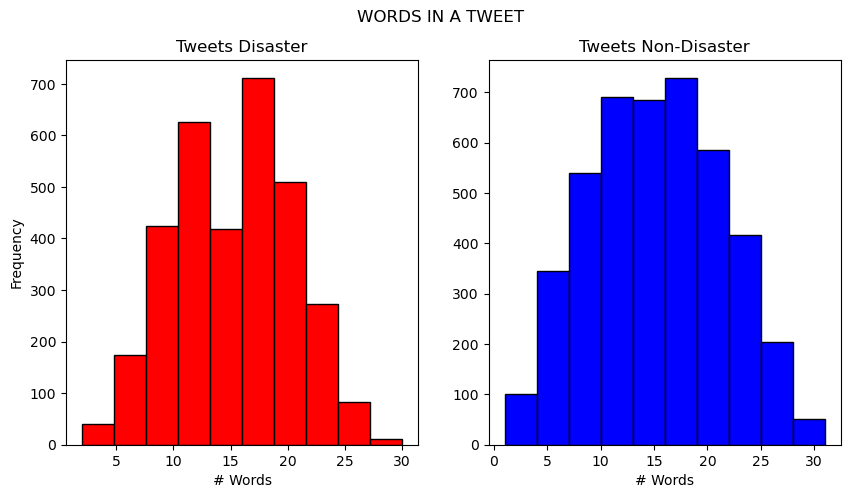

In [12]:
text_length = train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('WORDS IN A TWEET')
ax1.hist(text_length, color='red', edgecolor='black')
ax1.set_title('Tweets Disaster')
ax1.set_xlabel('# Words')
ax1.set_ylabel('Frequency')
text_length = train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_length,color='blue', edgecolor='black')
ax2.set_title('Tweets Non-Disaster')
ax2.set_xlabel('# Words')

Above we have a histogram of the average number of words in each text for both disaster and non-disaster related Tweets.
In both cases, the average number of words tends to be approximately 15 with more variance from the average for disaster versus non-disaster tweets.

Text(0.5, 1.0, 'Negative')

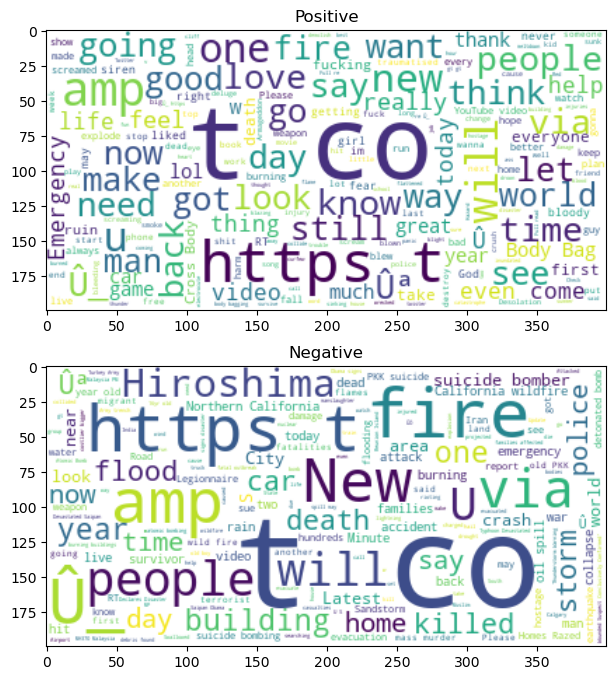

In [13]:
positive_cases = "".join(train_data[train_data['target'] == 0]['text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

The above word cloud shows the most frequent words for each of our target categories.  While some trends start appearing, the data overall seems 'messy' with an opportunity to clean it up for greater insight and accuracy.  Below we will clean the data by removing:

* Punctation
* Common stopwords  
* Words less than 4 letters
* Non-alphabet characters


In [14]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 letters
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])


In [18]:
train_data['clean_text'] = train_data['text'].apply(lambda x: x.lower())
train_data['clean_text'] = train_data['clean_text'].apply(remove_less_than)
train_data['clean_text'] = train_data['clean_text'].apply(remove_non_alphabet)
train_data['clean_text'] = train_data['clean_text'].apply(remove_stopwords)
train_data['clean_text'] = train_data['clean_text'].apply(remove_punctuation)
print('done')

done


In [19]:
train_data.head(5)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked notified evacuation shelter pl...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,sent photo ruby smoke pours school


Text(0.5, 1.0, 'Negative')

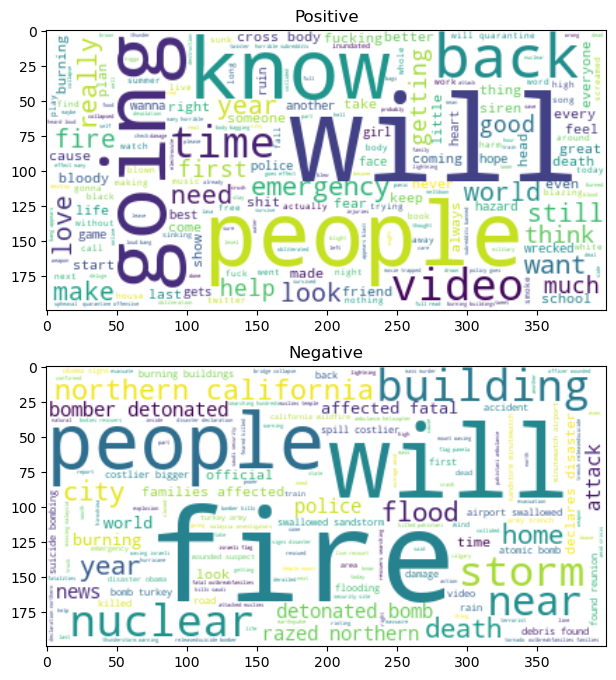

In [20]:
positive_cases = "".join(train_data[train_data['target'] == 0]['clean_text'].values)
negative_cases = "".join(train_data[train_data['target'] == 1]['clean_text'].values)

fig, axs = plt.subplots(2, 1, figsize=(20, 8))

wc1 = WordCloud(background_color='white').generate(positive_cases)
wc2 = WordCloud(background_color='white').generate(negative_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Positive')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Negative')

# **Model Architecture**

In [21]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
x = tokenizer.texts_to_sequences(train_data['clean_text'].values)
x = pad_sequences(x)
x.shape

(7613, 16)

In [22]:
#XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that can accelerate TensorFlow models with potentially no source code changes.
# reference: https://www.tensorflow.org/xla
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [24]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


# **Results and Analysis**

In [26]:
y = train_data['target']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 777)

In [27]:
model.fit(x_train, y_train, epochs = 10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
191/191 [==============================] - 9s 28ms/step - loss: 0.5595 - accuracy: 0.7057 - val_loss: 0.4855 - val_accuracy: 0.7794
Epoch 2/10
191/191 [==============================] - 4s 23ms/step - loss: 0.3907 - accuracy: 0.8259 - val_loss: 0.5154 - val_accuracy: 0.7735
Epoch 3/10
191/191 [==============================] - 4s 23ms/step - loss: 0.3371 - accuracy: 0.8534 - val_loss: 0.5489 - val_accuracy: 0.7551
Epoch 4/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3064 - accuracy: 0.8688 - val_loss: 0.5838 - val_accuracy: 0.7603
Epoch 5/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2807 - accuracy: 0.8819 - val_loss: 0.6162 - val_accuracy: 0.7433
Epoch 6/10
191/191 [==============================] - 4s 22ms/step - loss: 0.2595 - accuracy: 0.8892 - val_loss: 0.6511 - val_accuracy: 0.7498
Epoch 7/10
191/191 [==============================] - 4s 22ms/step - loss: 0.2382 - accuracy: 0.8970 - val_loss: 0.7117 - val_accuracy: 0.7531

In [29]:
y_pred = model.predict(x_test).round()
print(y_pred)

48/48 [==============================] - 0s 5ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


<AxesSubplot:>

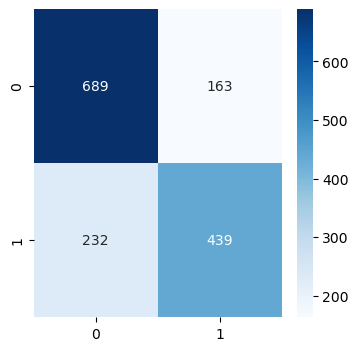

In [55]:
confuse = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(confuse, annot=True, fmt='g', cmap='Blues')

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       852
           1       0.73      0.65      0.69       671

    accuracy                           0.74      1523
   macro avg       0.74      0.73      0.73      1523
weighted avg       0.74      0.74      0.74      1523



# **Submission**

In [32]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
test_data['clean_text'] = test_data['text'].apply(lambda x: x.lower())
test_data['clean_text'] = test_data['clean_text'].apply(remove_less_than)
test_data['clean_text'] = test_data['clean_text'].apply(remove_non_alphabet)
test_data['clean_text'] = test_data['clean_text'].apply(remove_stopwords)
test_data['clean_text'] = test_data['clean_text'].apply(remove_punctuation)

l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['clean_text'].values)
x = tokenizer.texts_to_sequences(train_data['clean_text'].values)
x = pad_sequences(x, maxlen =l)

tokenizer.fit_on_texts(train_data['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test_data['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

print('done')

done


In [34]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [35]:
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x,y, epochs = 10,validation_split = 0.2 ,batch_size=32) #callbacks=[es_callback], 

Epoch 1/10
191/191 [==============================] - 40s 169ms/step - loss: 0.5455 - accuracy: 0.7204 - val_loss: 0.5127 - val_accuracy: 0.7472
Epoch 2/10
191/191 [==============================] - 30s 156ms/step - loss: 0.3731 - accuracy: 0.8363 - val_loss: 0.5561 - val_accuracy: 0.7360
Epoch 3/10
191/191 [==============================] - 30s 155ms/step - loss: 0.3024 - accuracy: 0.8754 - val_loss: 0.6453 - val_accuracy: 0.7190
Epoch 4/10
191/191 [==============================] - 31s 161ms/step - loss: 0.2508 - accuracy: 0.8970 - val_loss: 0.6623 - val_accuracy: 0.7183
Epoch 5/10
191/191 [==============================] - 29s 151ms/step - loss: 0.2042 - accuracy: 0.9123 - val_loss: 0.8980 - val_accuracy: 0.7131
Epoch 6/10
191/191 [==============================] - 29s 153ms/step - loss: 0.1696 - accuracy: 0.9279 - val_loss: 1.0407 - val_accuracy: 0.7098
Epoch 7/10
191/191 [==============================] - 28s 148ms/step - loss: 0.1406 - accuracy: 0.9384 - val_loss: 1.1168 - val_ac

In [36]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 3s 24ms/step


Text(0, 0.5, 'Count')

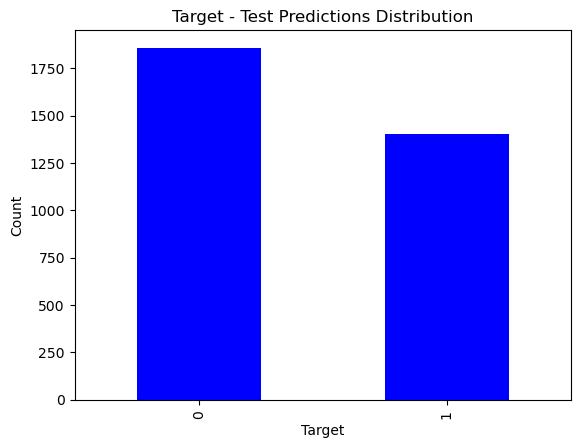

In [37]:
submission.groupby(['target'])['target'].count().plot(kind='bar', color = 'blue', title='Target - Test Predictions Distribution')
plt.xlabel('Target')
plt.ylabel('Count')

# **Conclusion**

adfadfadfadf